# Fraud Detection in Financial Transactions

**Objective:** Identify fraudulent transactions from synthetic financial data.

**Deliverables:**

- Data preprocessing and visualization
- Class balancing (SMOTE or undersampling)
- Random Forest / Gradient Boosting model
- Confusion matrix, Precision/Recall analysis

## Step-01 Load Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score

from imblearn.over_sampling import SMOTE
import joblib

In [2]:
!pip install imbalanced-learn

## Step-02 Load Dataset

In [2]:
n = 50000

df = pd.DataFrame({
    'TransactionID': np.arange(n),
    'Amount': np.round(np.random.exponential(scale=100, size=n), 2),
    'Time': np.random.randint(0, 86400, size=n),  # seconds in a day
    'Location': np.random.choice(['NY', 'CA', 'TX', 'FL'], size=n),
    'Device': np.random.choice(['Mobile', 'Web', 'ATM'], size=n),
    'IsFraud': np.random.choice([0, 1], size=n, p=[0.98, 0.02])
})
df.head()

,TransactionID,Amount,Time,Location,Device,IsFraud
0,0,6.52,31328,TX,ATM,0
1,1,739.41,29623,NY,ATM,0
2,2,75.85,21525,TX,Web,0
3,3,292.08,64947,FL,Mobile,0
4,4,83.88,69367,TX,Mobile,0


In [3]:
print(f"Number of Records: {df.shape[0]}")
print(f"Number of Features: {df.shape[1]}")

Number of Records: 50000
Number of Features: 6


## Step-03 Data Preprocessing

* **Let's check Information about dataset**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   TransactionID  50000 non-null  int32  
 1   Amount         50000 non-null  float64
 2   Time           50000 non-null  int32  
 3   Location       50000 non-null  object 
 4   Device         50000 non-null  object 
 5   IsFraud        50000 non-null  int32  
dtypes: float64(1), int32(3), object(2)
memory usage: 1.7+ MB


* **Let's check NULL values in dataset**

In [5]:
df.isnull().sum()/len(df) * 100

TransactionID    0.0
Amount           0.0
Time             0.0
Location         0.0
Device           0.0
IsFraud          0.0
dtype: float64

In [6]:
df.columns

Index(['TransactionID', 'Amount', 'Time', 'Location', 'Device', 'IsFraud'], dtype='object')

In [7]:
df["IsFraud"].value_counts()

IsFraud
0    48985
1     1015
Name: count, dtype: int64

* **Let's drop TransactionID from dataset**

In [8]:
#df = df.drop(columns = ['IsFraud'], axis = 1)
df = df.iloc[:,1:]

In [9]:
df['Device'].value_counts()

Device
Web       16804
ATM       16619
Mobile    16577
Name: count, dtype: int64

In [10]:
df_encoded = pd.get_dummies(df, columns = ['Location', 'Device'])

In [11]:
corr_matrix = df_encoded.corr(numeric_only=True)
corr_matrix

,Amount,Time,IsFraud,Location_CA,Location_FL,Location_NY,Location_TX,Device_ATM,Device_Mobile,Device_Web
Amount,1.000000,-0.004242,0.005042,0.004010,0.009104,-0.007785,-0.005332,0.001261,-0.007821,0.006536
Time,-0.004242,1.000000,0.003223,0.002319,-0.004286,-0.000270,0.002224,-0.000377,-0.004359,0.004720
IsFraud,0.005042,0.003223,1.000000,-0.002458,-0.000390,0.003604,-0.000751,0.002599,-0.002263,-0.000337
Location_CA,0.004010,0.002319,-0.002458,1.000000,-0.334390,-0.335984,-0.334480,-0.005010,-0.000457,0.005452
Location_FL,0.009104,-0.004286,-0.000390,-0.334390,1.000000,-0.332177,-0.330690,-0.000998,0.005140,-0.004127
Location_NY,-0.007785,-0.000270,0.003604,-0.335984,-0.332177,1.000000,-0.332266,-0.001249,0.003999,-0.002740
Location_TX,-0.005332,0.002224,-0.000751,-0.334480,-0.330690,-0.332266,1.000000,0.007288,-0.008688,0.001391
Device_ATM,0.001261,-0.000377,0.002599,-0.005010,-0.000998,-0.001249,0.007288,1.000000,-0.496916,-0.502014
Device_Mobile,-0.007821,-0.004359,-0.002263,-0.000457,0.005140,0.003999,-0.008688,-0.496916,1.000000,-0.501065
Device_Web,0.006536,0.004720,-0.000337,0.005452,-0.004127,-0.002740,0.001391,-0.502014,-0.501065,1.000000


* **Let's check Correlation with heatmap**

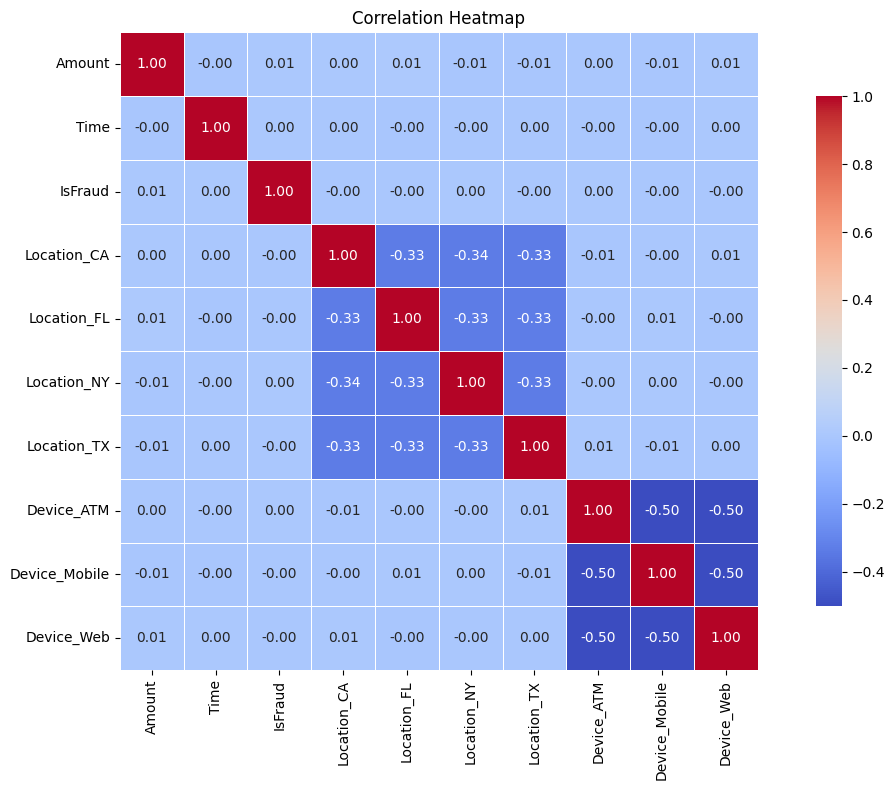

In [12]:
# Plot the heatmap
plt.figure(figsize=(12, 8))  # Adjust size as needed
sns.heatmap(corr_matrix, 
            annot=True,        # Show values in boxes
            fmt=".2f",         # Format for numbers
            cmap="coolwarm",   # Color palette
            square=True,       # Square cells
            linewidths=0.5,    # Grid lines
            cbar_kws={"shrink": 0.8})  # Colorbar size

plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

## Step-03 Splitting dataset into Training and Testing

In [13]:
X = df_encoded.drop(columns=['IsFraud'], axis = 1)
y = df_encoded['IsFraud']

X_train, X_test , y_train , y_test = train_test_split(X,y, test_size = 0.2 , random_state= 42)

## Step-04 Apply SMOTE - Synthetic Minority Over-sampling Technique

- It’s used to balance imbalanced datasets by creating new synthetic examples of the minority class.
- The model sees too few frauds and may just predict “Not Fraud” all the time.
💥 This is where SMOTE helps!

| IsFraud | Count  |
| ------- | ------ |
| 0       | 49,031 |
| 1       | 969    |


In [14]:
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

In [15]:
print("Before SMOTE:\n", y_train.value_counts())
print("After SMOTE:\n", y_train_bal.value_counts())

Before SMOTE:
 IsFraud
0    39168
1      832
Name: count, dtype: int64
After SMOTE:
 IsFraud
0    39168
1    39168
Name: count, dtype: int64


## Step-05  Model Selection

#### (i) Apply Random Forest

In [16]:
model_rf = RandomForestClassifier(random_state = 42)
model_rf.fit(X_train_bal, y_train_bal)

RandomForestClassifier(random_state=42)

#### (ii) Apply Gradient Boosting

In [18]:
model_gb = GradientBoostingClassifier(random_state=42)
model_gb.fit(X_train_bal, y_train_bal)

GradientBoostingClassifier(random_state=42)

## Step-06 Model Prediction

In [20]:
y_pred_rf = model_rf.predict(X_test)
y_pred_gb = model_gb.predict(X_test)

## Step-07 Model Evaluation

#### Evaluation of Random Forest Classifier

In [22]:
Accuracy = accuracy_score(y_test, y_pred_rf)
ra_score = roc_auc_score(y_test , y_pred_rf)
cf = confusion_matrix(y_test , y_pred_rf)
cr = classification_report(y_test, y_pred_rf)

print(f"Acccuracy of Random Forest Model: {Accuracy:.2f}")
print(f"ROC AUC Score: {ra_score:.2f}")
print("Confusion Matrix:\n", cf)
print("Classification Report:\n", cr)


Acccuracy of Random Forest Model: 0.97
ROC AUC Score: 0.50
Confusion Matrix:
 [[9736   81]
 [ 182    1]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      9817
           1       0.01      0.01      0.01       183

    accuracy                           0.97     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       0.96      0.97      0.97     10000



#### Evaluation of Gradient Boosting Classifier

In [23]:
Accuracy = accuracy_score(y_test, y_pred_gb)
ra_score = roc_auc_score(y_test , y_pred_gb)
cf = confusion_matrix(y_test , y_pred_gb)
cr = classification_report(y_test, y_pred_gb)

print(f"Acccuracy of Gradient Boosting Model: {Accuracy:.2f}")
print(f"ROC AUC Score: {ra_score:.2f}")
print("Confusion Matrix:\n", cf)
print("Classification Report:\n", cr)

Acccuracy of Gradient Boosting Model: 0.98
ROC AUC Score: 0.50
Confusion Matrix:
 [[9817    0]
 [ 183    0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      9817
           1       0.00      0.00      0.00       183

    accuracy                           0.98     10000
   macro avg       0.49      0.50      0.50     10000
weighted avg       0.96      0.98      0.97     10000



c:\Users\Sobia Alamgir\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Sobia Alamgir\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Sobia Alamgir\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

## Step-08 Save and Load Model

In [27]:
model_rf = joblib.dump(model_rf, 'random_forest_model.pkl')
model_gb = joblib.dump(model_gb, 'gradient_boosting_model.pkl')

In [18]:
model_rf = joblib.load('random_forest_model.pkl')
model_gb = joblib.load('gradient_boosting_model.pkl')

## Step-09 Creare dataframe with predicted values

In [29]:
y_pred_rf = y_pred_gb[:50000]

In [30]:
dataframe_rf = pd.DataFrame({"Actual_Fraud": y_test , "Predicted_Fraud": y_pred_rf})
dataframe_rf

,Actual_Fraud,Predicted_Fraud
33553,0,0
9427,0,0
199,0,0
12447,0,0
39489,0,0
...,...,...
28567,0,0
25079,0,0
18707,0,0
15200,0,0


## Step-10 Data Visualization